In [0]:
!pip install pandas

In [0]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ISI/Fer2013.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [0]:
raw_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
raw_data["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

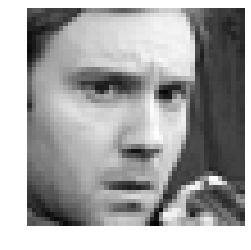

In [0]:
import numpy as np

img = raw_data["pixels"][0] # first image
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255
x_reshaped = x_pixels.reshape(48,48)

#%matplotlib inline # only if running in jupyter notebook
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(x_reshaped, cmap= "gray", interpolation="nearest")    
plt.axis("off")
plt.show()

In [0]:
def duplicate( array_input, size ):
  vg_input = np.empty([size, 48, 48, 3])
  for index, item in enumerate(vg_input):
      item[:, :,0] = array_input[index]
      item[:, :,1] = array_input[index]
      item[:, :,2] = array_input[index]
  return vg_input

In [0]:
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding
from keras.optimizers import SGD, adam

X_train, y_train = list(),list()
#raw_training = raw_data[raw_data["Usage"] == "Training"]

f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/X_train-5.pkl.gz", 'rb')
X_train = pickle.load(f)
f.close()

f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/y_trainp.pkl.gz", 'rb')
y_train = pickle.load(f)
f.close()

#for img in varxtrain:
#  img /= 255
#  X_train.append( img.reshape(48,48) )

#for img in raw_training["pixels"]:
#  val = img.split(" ")
#  x_pixels = np.array(val, 'float32')
#  x_pixels /= 255
#  X_train.append( x_pixels.reshape(48,48) )

x_train_matrix = np.array(X_train,dtype='float32')
X_train = duplicate( x_train_matrix, len(X_train))

#for emotion in raw_training["emotion"]:
#  y_train.append( emotion )
  
X_train = np.array(X_train, dtype = 'float32')
#y_train = np.array(np_utils.to_categorical(y_train), dtype = 'int16')
y_train = np.array( y_train, dtype='int16' )

print(X_train.shape)
print(y_train.shape)

(28709, 48, 48, 3)
(28709, 7)


In [0]:
vgg16 = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')

def get_vgg16_output(vgg16, array_input, n_feature_maps):
  vg_input = duplicate(array_input, n_feature_maps)
  picture_train_features = vgg16.predict(vg_input)
  del (vg_input)
  feature_map = np.empty([n_feature_maps, 512])
  for idx_pic, picture in enumerate(picture_train_features):
      feature_map[idx_pic] = picture
  return feature_map


x_train_feature_map = get_vgg16_output(vgg16, x_train_matrix, len(x_train_matrix) )
print(x_train_feature_map.shape)

(28709, 512)


In [0]:
X_test, y_test = list(),list()
#raw_training = raw_data[raw_data["Usage"] == "PublicTest"]

f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/X_test-5.pkl.gz", 'rb')
X_test = pickle.load(f)
f.close()

f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/y_test.pkl.gz", 'rb')
y_test = pickle.load(f)
f.close()

#for img in varxtest:
#  img /= 255
 # X_test.append( img.reshape(48,48) )

#for img in raw_training["pixels"]:
#  val = img.split(" ")
#  x_pixels = np.array(val, 'float32')
#  x_pixels /= 255
#  X_test.append( x_pixels.reshape(48,48) )

x_test_matrix = np.array(X_test,dtype='float32')
X_test = duplicate( x_test_matrix, len(X_test))

#for emotion in raw_training["emotion"]:
#  y_test.append( emotion )
  
X_test = np.array(X_test, dtype = 'float32')
#y_test = np.array(np_utils.to_categorical(y_test), dtype = 'int16')
y_test = np.array( y_train, dtype='int16' )

print(X_test.shape)
print(y_test.shape)

x_test_feature_map = get_vgg16_output(vgg16, x_test_matrix, len(x_test_matrix) )
print(x_test_feature_map.shape)

(3589, 48, 48, 3)
(3589, 7)
(3589, 512)


In [0]:
#Modelo

topLayerModel = Sequential()
topLayerModel.add(Dense(256, input_shape=(512,), activation='relu'))
topLayerModel.add(Dense(256, input_shape=(256,), activation='relu'))
topLayerModel.add(Dropout(0.5))
topLayerModel.add(Dense(128, input_shape=(256,), activation='relu'))
topLayerModel.add(Dense(7, activation='softmax'))

adamax = adam()
topLayerModel.compile(loss='categorical_crossentropy',optimizer=adamax, metrics=['accuracy'])
topLayerModel.fit(x_train_feature_map, y_train, validation_data=(x_train_feature_map, y_train),nb_epoch=30, batch_size= 10) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 28709 samples, validate on 28709 samples
Epoch 1/30
28709/28709 [==============================] - 19s 656us/step - loss: 1.6601 - acc: 0.3446 - val_loss: 1.6014 - val_acc: 0.3510
Epoch 2/30
28709/28709 [==============================] - 17s 595us/step - loss: 1.5773 - acc: 0.3857 - val_loss: 1.5338 - val_acc: 0.4151
Epoch 3/30
28709/28709 [==============================] - 17s 582us/step - loss: 1.5390 - acc: 0.4074 - val_loss: 1.5188 - val_acc: 0.4196
Epoch 4/30
28709/28709 [==============================] - 17s 584us/step - loss: 1.5123 - acc: 0.4150 - val_loss: 1.4676 - val_acc: 0.4340
Epoch 5/30
28709/28709 [==============================] - 17s 593us/step - loss: 1.4832 - acc: 0.4300 - val_loss: 1.4275 - val_acc: 0.4574
Epoch 6/30
28709/28709 [==============================] - 17s 588us/step - loss: 1.4607 - acc: 0.4414 - val_loss: 1.4053 - val_acc: 0.4655
Epoch 7/30
28709/28709 [==============================] - 17s 593us/step - loss: 1.4388 - acc: 0.4491 - val_loss: 1.

In [0]:
scores = topLayerModel.evaluate( x_test_feature_map,y_test)
print("\n%s: %.2f%%" %( topLayerModel.metrics_names[1], scores[1] * 100 ) )

3589/3589 [==============================] - 0s 63us/step

acc: 44.05%


In [0]:
topLayerModel.predict(x_test_feature_map)

array([[9.9819046e-01, 2.7983482e-10, 9.1971504e-04, ..., 1.7640973e-04,
        5.2865135e-04, 1.8071340e-04],
       [7.2192341e-02, 2.6651682e-02, 1.7159510e-02, ..., 8.6402446e-01,
        4.3808579e-04, 1.4379842e-02],
       [4.5712695e-02, 5.2317486e-05, 1.2938438e-02, ..., 7.2441794e-02,
        3.4214760e-04, 1.5366798e-02],
       ...,
       [6.1052464e-02, 2.9929265e-04, 9.5456861e-02, ..., 1.1936296e-01,
        6.3531712e-02, 6.0606283e-01],
       [1.0473210e-01, 6.0193422e-03, 6.1466169e-02, ..., 1.3941498e-01,
        1.8825296e-02, 1.9774710e-01],
       [1.4282213e-01, 1.3277132e-02, 1.5288091e-01, ..., 2.5371614e-01,
        3.9763667e-02, 3.3181337e-01]], dtype=float32)

Mezcla!!!
Investigando esta mezcla lo que hace es hacer que cualquier imagen de entrada pueda ser procesada y evaluada, por el modelo

In [0]:
inputs = Input(shape=(48, 48, 3))
vg_output = vgg16(inputs)
print("vg_output: {}".format(vg_output.shape))


model_predictions = top_layer_model(vg_output)
final_model = Model(input=inputs, output=model_predictions)
final_model.compile(loss='categorical_crossentropy',optimizer=adamax, metrics=['accuracy'])
final_model_score = final_model.evaluate(x_train_input, y_train, batch_size=FLAGS.batch_size)
print("Sanity check - final_model (train score): {}".format(final_model_score))


final_model_score = final_model.evaluate(x_test_input, y_test, batch_size=FLAGS.batch_size)
print("Sanity check - final_model (test score): {}".format(final_model_score))

model_to_save = final_model
print("Model input name: {}".format(model_to_save.input))
print("Model output name: {}".format(model_to_save.output))

Guardar modelo

In [0]:
builder = saved_model_builder.SavedModelBuilder(FLAGS.export_path)
signature = predict_signature_def(inputs={'images': model_to_save.input},
                                  outputs={'scores': model_to_save.output})
with K.get_session() as sess:
    builder.add_meta_graph_and_variables(sess=sess,
                                         tags=[tag_constants.SERVING],
                                         signature_def_map={'predict': signature})
    builder.save()